In [53]:
"""
임포트
"""
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import re

In [50]:
# """
# 데이터 파싱
# """
# values = []

# def parse_file_content(root_path, is_summary, section, file_count):
#   folder_sort = ["News Articles", "Summaries"]
	
#   if is_summary:
#     index = 1
#   else:
#     index = 0
   
# 	# 파일 열기
#   file_name = ('%d' % file_count).zfill(3) + '.txt'
#   path = "%s/%s/%s/%s" % (root_path, folder_sort[index], section, file_name)
#   file = open(path, 'rt', encoding='UTF-8')
	
# 	# 파일 한줄씩 읽어서 content에 넣기
#   content = ''
#   while True:
#     line = file.readline()
#     if not line:
#       break
#     content = ''.join(line)
	
# 	# 파일 닫기
#   file.close()
	
# 	# 파일 내용 반환
#   return content

  
# def parse_folder(root_path, section):
#   folder_path = "%s/Summaries/%s/" % (root_path, section)
#   file_list = os.listdir(folder_path)
#   max_file_count = len(file_list)
  
#   for i in range(1, max_file_count + 1):
#     # Text 데이터 가져오기
#     text = parse_file_content(root_path=root_path, is_summary=False, section=section, file_count=i)
    
# 		# Summary 데이터 가져오기
#     summary = parse_file_content(root_path=root_path, is_summary=True, section=section, file_count=i)
		
# 		# values에 데이터 넣기
#     values.append([text, summary])

# # 모든 섹션들 데이터에 넣기
# root_path = "./BBC News Summary"
# parse_folder(root_path, "business")
# parse_folder(root_path, "entertainment")
# parse_folder(root_path, "politics")
# parse_folder(root_path, "sport")
# parse_folder(root_path, "tech")

# # 데이터프레임 만들어 csv 파일로 저장
# df = pd.DataFrame(values)
# df.columns = ["Text", "Summary"]
# df.to_csv("News.csv", index=False)

In [54]:
"""
전처리
"""
df = pd.read_csv("News.csv")

# print(df)
print("전체 데이터 갯수 :", len(df))
# print(df.isnull().sum())

전체 데이터 갯수 : 2225


In [55]:
texts = []
for content in df['Text']:
    content = re.sub(r"([?.!,])", r" \1 ", content)
    content = content.strip()
    texts.append(content)

summaries = []
for content in df['Summary']:
    content = re.sub(r"([?.!,])", r" \1 ", content)
    content = content.strip()
    summaries.append(content)
# print(text[:5])
# print(summarys[:5])

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    texts + summaries, target_vocab_size=2**13
)
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
VOCAB_SIZE = tokenizer.vocab_size + 2

print("시작 토큰 번호 :", START_TOKEN)
print("종료 토큰 번호 :", END_TOKEN)
print("단어 집합의 크기 :", VOCAB_SIZE)


시작 토큰 번호 : [8191]
종료 토큰 번호 : [8192]
단어 집합의 크기 : 8193


In [56]:
# print('임의의 질문 샘플을 정수 인코딩 : {}'.format(tokenizer.encode(texts[20])))

sample_string = texts[20]

tokenized_string = tokenizer.encode(sample_string)
print('정수 인코딩 후의 문장 : {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print('기존 문장 : {}'.format(original_string))

for ts in tokenized_string:
    print('{} ----> {}'.format(ts, tokenizer.decode([ts])))

정수 인코딩 후의 문장 : [4369, 178, 122, 5486, 3, 3507, 48, 14, 54, 6215, 109, 2, 1053, 8, 5, 5018, 8, 1274, 2, 241, 3492, 28, 54, 3741, 7967, 4681, 4873, 3, 54, 7781, 8050, 41, 6104, 4, 47, 25, 50, 7, 2805, 10, 75, 55, 4029, 2911, 8052, 4250, 7967, 7428, 848, 2, 47, 1016, 5, 2570, 110, 3846, 5, 2599, 8050, 10, 292, 2, 13, 350, 12, 324, 22, 307, 3443, 10, 710, 107, 20, 137, 954, 269, 123, 2037, 6, 4111, 14, 7, 7129, 2175, 269, 123, 3640, 7985, 6, 1910, 7967, 5, 3707, 3167, 54, 935, 9, 3683, 3, 3846, 34, 8021, 4232, 7967, 356, 74, 116, 20, 43, 5992, 170, 1782, 11, 7, 1324, 7719, 51, 4502, 158, 10, 93, 274, 11, 1, 230, 2042, 3, 2770, 14, 1, 5612, 2, 49, 17, 148, 1228, 34, 1, 2455, 4844, 92, 3351, 60, 293, 3, 18, 149, 79, 90, 20, 3346, 54, 1228, 14, 1253, 10, 1611, 2737, 7967, 1, 230, 12, 293, 3, 329, 7, 6796, 7967, 2291, 9, 800, 408, 7980, 265, 954, 168, 123, 762, 4249, 2397, 123, 5330, 111, 84, 76, 10, 1316, 2873, 9, 1, 5330, 6076, 7967, 1, 230, 16, 7, 965, 132, 157, 3269, 5, 5055, 7209, 11, 155

In [57]:
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (content1, content2) in zip(inputs, outputs):
        content1 = START_TOKEN + tokenizer.encode(content1) + END_TOKEN
        content2 = START_TOKEN + tokenizer.encode(content2) + END_TOKEN

        tokenized_inputs.append(content1)
        tokenized_outputs.append(content2)
    
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_inputs, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_outputs, padding='post')

    return tokenized_inputs, tokenized_outputs

texts, summaries = tokenize_and_filter(texts, summaries)

In [58]:

print("기사 데이터의 크기(shape) :", texts.shape)
print("요약 데이터의 크기(shape) :", summaries.shape)

print(texts[0])
print(summaries[0])

기사 데이터의 크기(shape) : (2225, 664)
요약 데이터의 크기(shape) : (2225, 3014)
[8191 6661 8036 7390 7967   12    3 5610  364   54 3514   22  205    4
 2885    3 5167 7967   43 3382   97 7497 7967   24   81  194 6827   10
   75   19  221 1447    3 1090   98 3249  111    3 2934 7967 7778    2
    9    7  308   13   12  238 3360   24    1 3519   10   15  196   17
   20   16 5340    3 3596 7967    1 1250   20  668    3  149 2840  483
   11  367 5611    2   47   20 1446  149  488   98 2314 8044   10   75
 4172    8    3 7383  291    1  151   20 3514   11    7  308   21 1011
  161 5178  103 1698 3164 3262 1620 7974    8 7596    4    7 1786    9
 7497 7967  618    2   47   20   46  844   22 4886 4975 2083   10   75
   29  122 1052    1  620    4   54 1786    9 7497 7967  645   22    7
 1923   14    1 1336    4   13 6784   23 8192    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0  

In [59]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((
    { 
        'inputs': texts,
        'dec_inputs': summaries[:, :-1]
    },
    {
        'outputs': summaries[:, 1:]
    }
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

print(summaries[0])
print(summaries[:1][:, :-1])
print(summaries[:1][:, 1:])

[8191 6661 8036 ...    0    0    0]
[[8191 6661 8036 ...    0    0    0]]
[[6661 8036 7390 ...    0    0    0]]


## transformer 아키텍처 구현
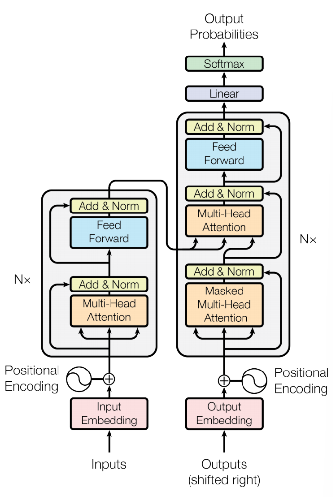

In [60]:
# 인코더&디코더(포지셔널 인코딩)
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        return position *  (1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32)))

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position = tf.range(position, dtype = tf.float32)[:, tf.newaxis],
            i = tf.range(d_model, dtype = tf.float32)[tf.newaxis, :],
            d_model = d_model
        )
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        angle_rads = np.zeros(angle_rads.shape)
        pos_encoding = tf.constant(angle_rads)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, tf.shape(inputs)[1], :]

In [61]:
#인코더(스케일드 닷 프로덕트 어텐션)
def scaled_dot_product_attention(query, key, value, mask) :
    multiple_QandK = tf.matmul(query, key, transpose_b=True)
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = multiple_QandK / tf.math.sqrt(depth)

    if mask is not None :
        logits += (mask * -1e10) 
    attention_weight = tf.nn.softmax(logits, axis = -1)
    output = tf.matmul(attention_weight, value)
    return output, attention_weight
        

In [62]:
# 패딩 마스크 생성
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x,0), tf.float32) # [[1,2,0,2,1]] => [[0.,0.,1.,0.,0.]]
    return mask[:,tf.newaxis, tf.newaxis, :] # 차원 추가

In [63]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1] # [[1,2,0]] => 3
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0) # 모든 원소가 1인 하삼각행렬
    padding_mask = create_padding_mask(x) # x에서 0이었던 부분만 1로 바꿔진 행렬
    return tf.maximum(look_ahead_mask, padding_mask)

In [64]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0 # d_model 사이즈의 행렬을 num_heads로 나눠야하기 때문
        
        self.depth = d_model // self.num_heads
        
        # Q, K, V 정의 : d_model 길이의 밀집층(가중치 행렬)
        self.query_dense = tf.keras.layers.Dense(units=d_model) # WQ
        self.key_dense = tf.keras.layers.Dense(units=d_model) # WK
        self.value_dense = tf.keras.layers.Dense(units=d_model) #WV
        
        # WO
        self.dense = tf.keras.layers.Dense(units=d_model)
    
    # num_heads 개수로 행렬 나누기
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0,2,1,3])
    
    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # 밀집층 지나기
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 헤드 나누기
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        #스케일 닷 프로덕트
        scaled_attention, attention_weight = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0,2,1,3])

        # concat
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        # WO 밀집층 지나기
        outputs = self.dense(concat_attention)

        return outputs

In [65]:
# 인코더 레이어
def encoder_layer(dff, d_model, num_heads, dropout, name = "encoder_layer") :
    inputs = tf.keras.Input(shape = (None, d_model), name = "inputs")
    padding_mask = tf.keras.Input(shape = (1, 1, None), name = "padding_mask")
    attention = MultiHeadAttention(
        d_model, num_heads, name = "attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [66]:
# real 인코더
def encoder(
    vocab_size, 
    num_layers, 
    dff, d_model, 
    num_heads, 
    dropout, 
    name="encoder"):

    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = encoder_layer(
            dff=dff, 
            d_model=d_model, 
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i))([outputs, padding_mask])
            
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)


## 디코더 구현
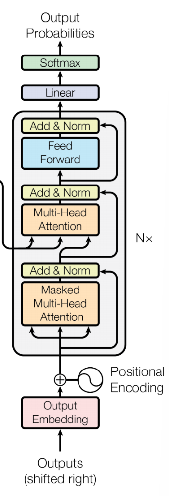

In [67]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    
    # mask
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # masked multi-head attention
    attention1 = MultiHeadAttention(d_model, num_heads, name="attention_1").call(inputs={"query":inputs, "key":inputs, "value":inputs, "mask":look_ahead_mask})

    # add, norm
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    # multi-head attention (encoder-decoder attention)
    attention2 = MultiHeadAttention(d_model, num_heads, name="attention_2").call(inputs={"query":attention1, "key":enc_outputs, "value":enc_outputs, "mask":padding_mask})

    # dropout, add, norm
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)
    
    # feed forward (dense layer)
    outputs = tf.keras.layers.Dense(units=dff, activation="relu")(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

In [68]:
def decoder(vocab_size, num_layers, dff, d_model, num_heads, dropout, name="decoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs") # outputs from encoder

    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask") # 
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    # output embedding
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads, dropout=dropout, name="decoder_layer_{}".format(i),)(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])
    
    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

## 트랜스포머

In [69]:
def transformer(vocab_size, num_layers, dff, d_model, num_heads, dropout, name="transformer"):
    
    # encoder input (keras tensor)
    enc_inputs = tf.keras.Input(shape=(None,), name="enc_inputs")

    # decoder input (keras tensor)
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # encoder padding mask (Lambda layer)
    enc_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name="enc_padding_mask")(enc_inputs)

    # decoder padding mask - first sub layer (Lambda layer)
    look_ahead_mask = tf.keras.layers.Lambda(create_look_ahead_mask, output_shape=(1, None, None), name="look_ahead_mask")(dec_inputs)

    # decoder padding mask - second sub layer (lambda layer)
    dec_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name="dec_padding_mask")(enc_inputs)

    # encoder (keras model)
    enc_outputs = encoder(vocab_size, num_layers, dff, d_model, num_heads, dropout,)(inputs=[enc_inputs, enc_padding_mask])

    # decoder (keras model)
    dec_outputs = decoder(vocab_size, num_layers, dff, d_model, num_heads, dropout,)(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[enc_inputs, dec_inputs], outputs=outputs, name=name)

In [70]:
# 하이퍼파라미터
small_transformer = transformer(
    vocab_size=9000,
    num_layers=4,
    dff=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="small_transformer"
) # d_v = 128 / num_heads

In [71]:
# 손실 함수 (cross entropy)
# 요약은 문장을 생성해내는 것이고, 이것은 단어 모음에 있는 단어 중
# 현재 문장 뒤에 올 단어 하나를 선택하는 다중 클래스 분류 문제이다.
# 따라서 cross entropy 함수를 손실함수로 사용한다.

MAX_LENTH = 1000

def loss_function(y, y_hat):
    y = tf.reshape(y, shape=(-1, MAX_LENTH -1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction="none")(y, y_hat)

    mask = tf.cast(tf.not_equal(y, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

## 데이터 정보
크기: 2225

